In [10]:
from wilcoxon import sheets
import seaborn as sns
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import contextily as ctx
import shapely
import geoplot
from wilcoxon.utils import *
from math import sin, cos, atan2, radians, sqrt
import itertools
from wilcoxon.spiderman import *
import re
from tqdm import tqdm
import collections

In [12]:
malls = sheets.getGeo("Malls Alternative")
malls = gpd.GeoDataFrame(malls, geometry = gpd.points_from_xy(malls.Longitude, malls.Latitude))
malls["Reverse"] = (101 - malls.Rank)*4

In [47]:
mrt = sheets.getGeo("MRT")
mrt.Name = mrt.Name.str.upper()
mrt = mrt[mrt.Label.str.contains("\D{2}")]
mrt.Label = mrt.groupby("Name").Label.transform(lambda x: ", ".join(set(x)))
mrtMapping = mrt.drop_duplicates("Name").set_index("Name").to_dict("index")

In [48]:
trainStationsRaw = gpd.read_file("Documents/Geospatial/GEOSPATIAL/TrainStation_Jan2020/MRTLRTStnPtt.shp")
trainStationsRaw["geometry"] = trainStationsRaw["geometry"].to_crs(epsg=4326)
trainStationExits = gpd.read_file("Documents/Geospatial/GEOSPATIAL/TrainStationExit_Jan2020/TrainStationExit06032020.shp")
trainStations = trainStationsRaw.merge(trainStationExits, on="STN_NAME", how="right")[["STN_NAME","geometry_x","geometry_y"]]
trainStations.columns = ["Name","Station","Exit"]
trainStations["Exit"] = trainStations["Exit"].apply(shapely.wkt.dumps).str.replace(" Z","").str.replace(" 0\.0+","").apply(shapely.wkt.loads)
trainStations = trainStations.melt(id_vars="Name",var_name="Type",value_name="geometry")
trainStations = gpd.GeoDataFrame(trainStations,geometry="geometry")
trainStations["Longitude"] = trainStations["geometry"].x
trainStations["Latitude"] = trainStations["geometry"].y
trainStations["Name"] = trainStations["Name"].str.replace(" .RT STATION","")
# trainStations["Label"] = trainStations["Name"].apply(lambda x: mrtMapping[x]["Label"])

In [49]:
mallsCoords = malls[["Latitude","Longitude"]].values.tolist()
trainStationsCoords = trainStations[trainStations["Name"].apply(lambda x: x in mrt["Name"].tolist())][["Latitude","Longitude","Name"]].values.tolist()
mrtCoords = mrt[["Lat","Long","Name"]].values.tolist()
trainStationsCoords.extend(mrtCoords)
results = []
for mCoord in mallsCoords:
    name = ""
    shortest = 1000000
    for tCoord in trainStationsCoords:
        try:
            distance = dist(mCoord[0],mCoord[1],tCoord[0],tCoord[1])
            if distance < shortest:
                shortest = distance
                name = tCoord[2]
        except: continue
    results.append([" ".join([x.capitalize() for x in name.split(" ")]),shortest * 1000,mrtMapping[name]["Label"]])

In [53]:
pd.DataFrame(results)[0].to_clipboard(index=False, header=False)

In [56]:
mrt[mrt.Name=="JURONG EAST"]

,Label,Name,Chinese,Address,Postcode,Lat,Long,Labels,Type,Origin,Destination,Net flow,geometry,color,Link
187,"NS1, EW24",JURONG EAST,裕廊东,10 Jurong East Street 12,609690.0,1.333153,103.742287,"NS1, EW24, JE5",Station,1976284.0,1970910.0,-5374,POINT (103.7422865440047 1.333152619894065),#D42E12,http://wikipedia.org/wiki/Jurong_East_MRT_station
188,"NS1, EW24",JURONG EAST,裕廊东,10 Jurong East Street 12,609690.0,1.333153,103.742287,"NS1, EW24, JE5",Station,1976284.0,1970910.0,-5374,POINT (103.7422865440047 1.333152619894065),#009645,http://wikipedia.org/wiki/Jurong_East_MRT_station


In [12]:
def rankToColor(x):
    if x < 7:
        return "#000000"
    elif x < 21:
        return "#E10105"
    elif x < 41:
        return "#97CDE1"
    elif x < 61:
        return "#EFD065"
    elif x < 91:
        return "#E1E1E1"
    else:
        return "#C17046"

malls["color"] = malls.Rank.map(rankToColor)

/Users/izzhafeez/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


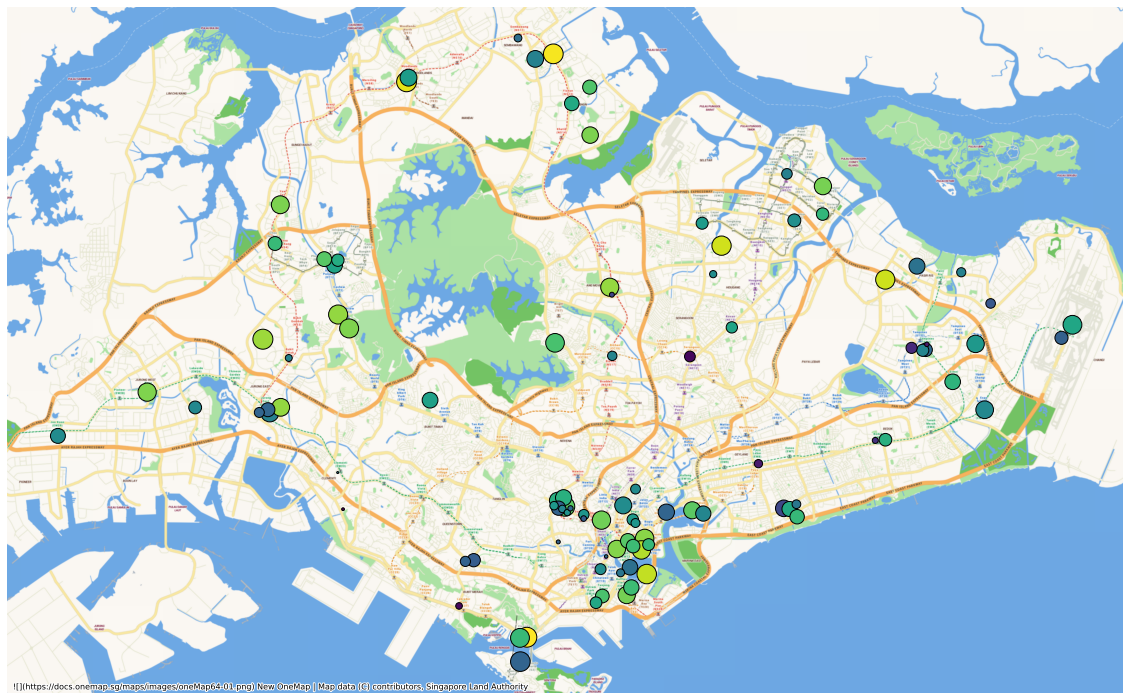

In [23]:
# sss = sns.color_palette("rocket_r",as_cmap=True)
# ax = trainStations.plot(figsize=(20,20))
# ax = malls.plot(figsize=(20,20),column="Rank",color=malls["color"],edgecolor="black",markersize="Reverse")
ax = malls.plot(figsize=(20,20),column="Win Rate",edgecolor="black",markersize="Reverse")
ax.set_axis_off()
ctx.add_basemap(ax,crs="EPSG:4326",source=ctx.providers.OneMapSG.Default,zoom=14)
# for x, y, label, rank in zip(malls.geometry.x, malls.geometry.y, malls.Name,malls.Rank):
#     if rank < 11:
#         ax.annotate(label, xy=(x, y), xytext=(12, 0), textcoords="offset points")

In [12]:
malls.columns.tolist()

['Name',
 'Latitude',
 'Longitude',
 'Distance',
 'Stores',
 'Halal',
 'Floors',
 'Area',
 'Date',
 'Alt',
 'Parking',
 'Services',
 'Shore',
 'Density',
 'Buildings',
 'Lot',
 'Origin',
 'Destination',
 'Flow',
 'Highest Bus',
 'Latitude.1',
 'Longitude.1',
 'Distance.1',
 'Stores.1',
 'Halal.1',
 'Floors.1',
 'Area.1',
 'Date.1',
 'Alt.1',
 'Parking.1',
 'Services.1',
 'Lot.1',
 'Flow.1',
 'Highest Bus.1',
 'Alphabet',
 'Buses',
 'Nearby Parking',
 'Station',
 'Abbreviation',
 'Label',
 'Link',
 'geometry',
 'Latitude.2',
 'Longitude.2',
 'Services.2',
 'Stores.2',
 'Halal.2',
 'Area.2',
 'Date.2',
 'Shore.1',
 'Latitude.3',
 'Longitude.3',
 'Service',
 'Stores.3',
 'Halal.3',
 'Area.3',
 'Date.3',
 'Shore.2',
 'Phase 1',
 'Phase 2',
 'Phase 3',
 'Phase 4',
 'Win Rate',
 'Assist 1',
 'Assist 2',
 'Assist 3',
 'Assist 4',
 'Assist Rank 1',
 'Assist Rank 2',
 'Assist Rank 3',
 'Assist Rank 4',
 'Combined 1',
 'Combined 2',
 'Combined 3',
 'Combined 4',
 'Combined Rate',
 'Combined Rank

In [17]:
malls

,Name,Latitude,Longitude,Distance,Stores,Halal,Floors,Area,Date,Alt,...,Balanced 3,Balanced 4,Balanced Rate,Score,Rank,Rank Diff,Assist Value,Rank No Assist,Assist Value 2,Reverse
0,Le Quest,1.355796,103.741292,590.529662,49,0,4.0,45000,2020,22.750,...,116.751352,120.000000,116.936491,117.202368,1,3,0.265877,2,1,400
1,VivoCity,1.264321,103.822309,0.000000,340,52,5.0,1076251,2006,3.750,...,118.001622,118.002810,116.943391,116.943391,2,14,0.000000,1,-1,396
2,Woods Square,1.434795,103.785383,235.457716,51,52,3.0,39264,2021,22.500,...,110.505001,118.010262,116.244605,116.433454,3,2,0.188849,4,1,392
3,Canberra Plaza,1.443381,103.830435,53.255217,70,2,4.0,88000,2020,5.625,...,111.269323,116.618568,116.347061,116.347061,4,-2,0.000000,3,-1,388
4,Resorts World Sentosa,1.256841,103.820313,862.109615,45,13,3.0,30000,2010,5.875,...,120.000000,119.500000,114.288662,115.716497,5,-4,1.427834,5,0,384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Bugis+,1.299613,103.854197,159.222521,150,44,10.0,202680,2009,4.375,...,95.000000,78.419647,88.277364,88.277364,116,-56,0.000000,113,-3,-60
116,Mandarin Gallery,1.302039,103.836430,257.835780,100,34,4.0,126282,2010,6.125,...,86.252815,87.031123,88.143869,88.143869,117,-15,0.000000,114,-3,-64
117,Sim Lim Square,1.303009,103.853026,49.428960,151,14,6.0,236881,1987,4.375,...,91.033021,100.000000,86.662238,86.662238,118,-10,0.000000,118,0,-68
118,Velocity@Novena Square,1.319947,103.843913,0.000000,160,34,3.0,170672,2000,7.500,...,84.512430,71.151606,85.470681,85.470681,119,-1,0.000000,119,0,-72
